Đang chạy Homework 5 - Phần 2:


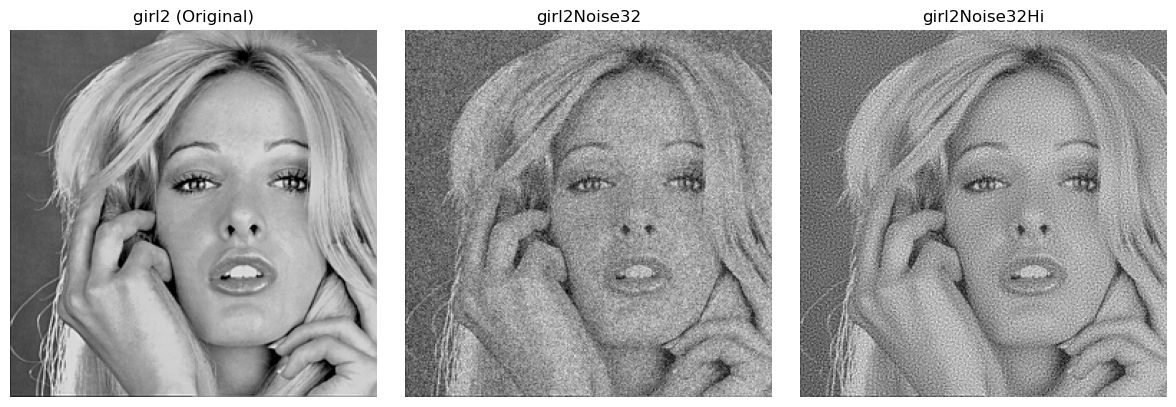

MSE girl2Noise32.bin: 744.4679
MSE girl2Noise32Hi.bin: 692.5051

Ideal LPF (cutoff 64):
MSE on girl2: 127.7481
MSE on girl2Noise32Hi: 398.9978
ISNR on girl2Noise32Hi: 2.3945 dB
MSE on girl2Noise32: 550.8787
ISNR on girl2Noise32: 1.3079 dB


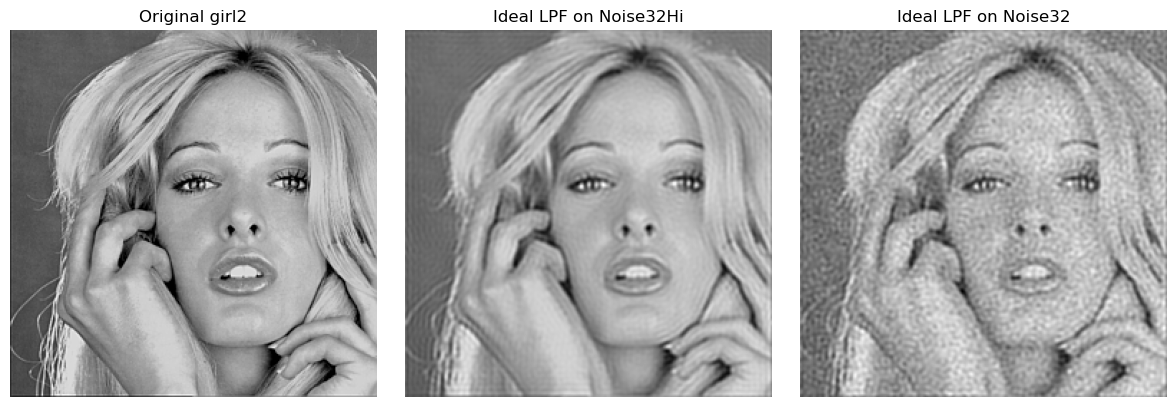


Gaussian LPF (cutoff 64):
MSE on girl2: 91.0134
MSE on girl2Noise32Hi: 422.7114
ISNR on girl2Noise32Hi: 2.1438 dB
MSE on girl2Noise32: 536.9898
ISNR on girl2Noise32: 1.4188 dB


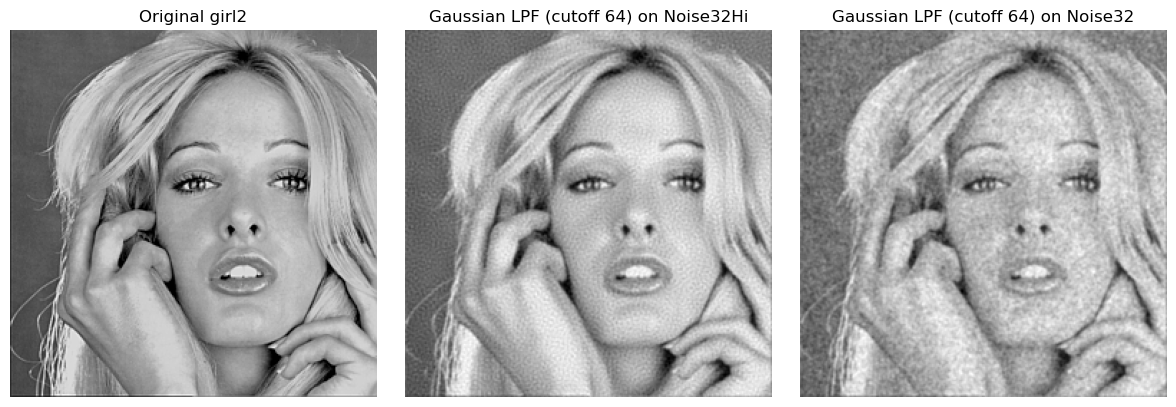


Gaussian LPF (cutoff 77.5):
MSE on girl2: 61.0887
MSE on girl2Noise32Hi: 413.7321
ISNR on girl2Noise32Hi: 2.2370 dB
MSE on girl2Noise32: 531.0888
ISNR on girl2Noise32: 1.4668 dB


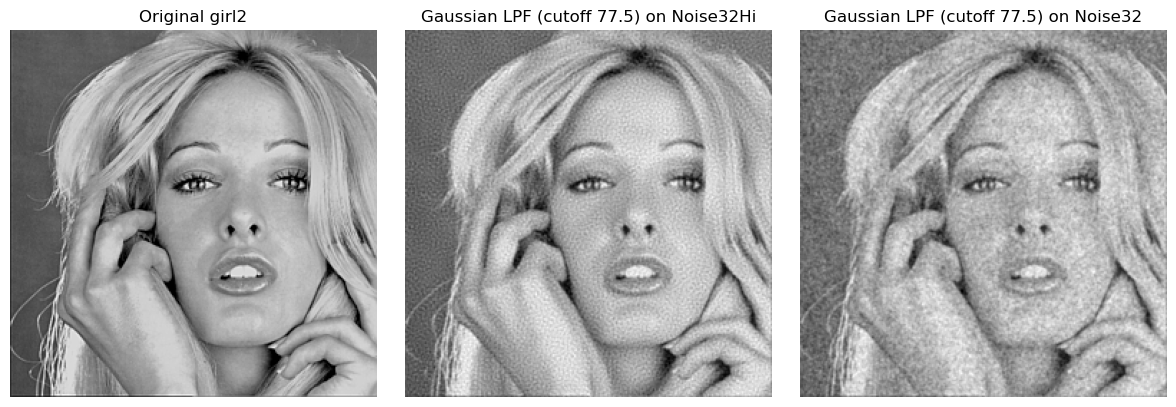

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Hàm đọc ảnh nhị phân (256x256) từ file .bin
def read_bin_image(filename, shape=(256,256)):
    data = np.fromfile(filename, dtype=np.uint8)
    return data.reshape(shape)

# Hàm thực hiện full-scale contrast stretch để đưa dải giá trị về 0-255 (dạng uint8)
def contrast_stretch(image):
    imin, imax = image.min(), image.max()
    if imax > imin:
        return ((image - imin) / (imax - imin) * 255).astype(np.uint8)
    else:
        return image.astype(np.uint8)

# Hàm tính MSE giữa ảnh gốc và ảnh ước lượng (float)
def compute_mse(original, processed):
    return np.mean((original - processed)**2)

# Hàm tính ISNR theo công thức: 10*log10(MSE(noisy) / MSE(original - filtered))
def compute_isnr(original, noisy, filtered):
    mse_noisy = compute_mse(original, noisy)
    mse_filtered = compute_mse(original, filtered)
    if mse_filtered == 0:
        return np.inf
    return 10 * np.log10(mse_noisy / mse_filtered)

# --------------------- Phần 2(a): Đọc, hiển thị và tính MSE ---------------------
def part2a():
    # Đọc ảnh gốc và hai ảnh nhiễu
    girl2 = read_bin_image("girl2.bin", (256,256)).astype(np.float32)
    girl2_noise = read_bin_image("girl2Noise32.bin", (256,256)).astype(np.float32)
    girl2_noise_hi = read_bin_image("girl2Noise32Hi.bin", (256,256)).astype(np.float32)
    
    # Hiển thị ảnh
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(contrast_stretch(girl2), cmap='gray')
    plt.title("girl2 (Original)")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(contrast_stretch(girl2_noise), cmap='gray')
    plt.title("girl2Noise32")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(contrast_stretch(girl2_noise_hi), cmap='gray')
    plt.title("girl2Noise32Hi")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Tính MSE so sánh với ảnh gốc
    mse_noise = compute_mse(girl2, girl2_noise)
    mse_noise_hi = compute_mse(girl2, girl2_noise_hi)
    
    print(f"MSE girl2Noise32.bin: {mse_noise:.4f}")
    print(f"MSE girl2Noise32Hi.bin: {mse_noise_hi:.4f}")
    
    # Trả về ảnh gốc và ảnh nhiễu dưới dạng float (không làm tròn) để dùng cho các phần tiếp theo
    return girl2, girl2_noise, girl2_noise_hi

# --------------------- Hàm tạo mặt nạ Ideal LPF ---------------------
def ideal_lpf_mask(shape=(256,256), cutoff=64):
    # Tạo lưới tần số từ -N/2 đến N/2 - 1
    N = shape[0]
    u = np.arange(-N//2, N//2)
    v = np.arange(-N//2, N//2)
    U, V = np.meshgrid(u, v)
    # Tạo mặt nạ hình tròn với bán kính cutoff
    mask = (np.sqrt(U**2 + V**2) <= cutoff).astype(np.float32)
    # Vì FFT của ảnh gốc ở dạng "centered" thì cần fftshift để đảm bảo sự tương thích
    mask = np.fft.ifftshift(mask)
    return mask

# --------------------- Hàm lọc ảnh theo DFT ---------------------
def dft_filter(image, H_mask):
    # Tính DFT 2D của ảnh (dạng float)
    F = np.fft.fft2(image)
    # Nhân điểm với mặt nạ H
    F_filtered = F * H_mask
    # Tính inverse DFT để thu được ảnh kết quả (chỉ lấy phần thực)
    filtered = np.fft.ifft2(F_filtered).real
    return filtered

# --------------------- Phần 2(b): Lọc bằng Ideal LPF ---------------------
def part2b(girl2):
    # Tạo mặt nạ Ideal LPF với cutoff = 64 cpi
    H_mask = ideal_lpf_mask(shape=(256,256), cutoff=64)
    
    # Lọc ảnh: áp dụng cho ảnh gốc, girl2Noise32, và girl2Noise32Hi
    girl2_filtered = dft_filter(girl2, H_mask)
    return H_mask, girl2_filtered

# --------------------- Hàm tạo mặt nạ Gaussian LPF ---------------------
def gaussian_lpf_mask(shape=(256,256), cutoff=64):
    # Tạo lưới tần số
    N = shape[0]
    u = np.arange(-N//2, N//2)
    v = np.arange(-N//2, N//2)
    U, V = np.meshgrid(u, v)
    # Tính sigma theo công thức: sigma = 0.19 * N / cutoff
    sigma = 0.19 * N / cutoff
    # Tạo mặt nạ Gaussian theo công thức:
    # H_tilde_center = exp(- (2*pi^2*sigma^2)/(N^2)*(U^2+V^2) )
    H_tilde_center = np.exp(- (2 * (np.pi**2) * (sigma**2) / (N**2)) * (U**2 + V**2))
    # Căn giữa (đưa về dạng uncentered)
    H_tilde = np.fft.ifftshift(H_tilde_center)
    return H_tilde

# --------------------- Phần 2(c): Lọc bằng Gaussian LPF với cutoff = 64 ---------------------
def part2c(girl2):
    H_gauss = gaussian_lpf_mask(shape=(256,256), cutoff=64)
    girl2_gauss = dft_filter(girl2, H_gauss)
    return H_gauss, girl2_gauss

# --------------------- Phần 2(d): Lọc bằng Gaussian LPF với cutoff = 77.5 ---------------------
def part2d(girl2):
    H_gauss = gaussian_lpf_mask(shape=(256,256), cutoff=77.5)
    girl2_gauss = dft_filter(girl2, H_gauss)
    return H_gauss, girl2_gauss

# --------------------- Chương trình chính cho Phần 2 ---------------------
if __name__ == '__main__':
    print("Đang chạy Homework 5 - Phần 2:")
    # Lấy ảnh gốc và ảnh nhiễu
    girl2, girl2_noise, girl2_noise_hi = part2a()
    
    # Phần 2(b): Lọc bằng Ideal LPF với cutoff 64
    H_ideal, girl2_filtered_ideal = part2b(girl2)
    girl2_noise_hi_filtered_ideal = dft_filter(girl2_noise_hi, H_ideal)
    girl2_noise_filtered_ideal = dft_filter(girl2_noise, H_ideal)
    
    # Tính MSE và ISNR cho Ideal LPF
    mse_ideal = compute_mse(girl2, girl2_filtered_ideal)
    mse_noise_hi_ideal = compute_mse(girl2, girl2_noise_hi_filtered_ideal)
    mse_noise_ideal = compute_mse(girl2, girl2_noise_filtered_ideal)
    isnr_noise_hi_ideal = compute_isnr(girl2, girl2_noise_hi, girl2_noise_hi_filtered_ideal)
    isnr_noise_ideal = compute_isnr(girl2, girl2_noise, girl2_noise_filtered_ideal)
    
    print(f"\nIdeal LPF (cutoff 64):")
    print(f"MSE on girl2: {mse_ideal:.4f}")
    print(f"MSE on girl2Noise32Hi: {mse_noise_hi_ideal:.4f}")
    print(f"ISNR on girl2Noise32Hi: {isnr_noise_hi_ideal:.4f} dB")
    print(f"MSE on girl2Noise32: {mse_noise_ideal:.4f}")
    print(f"ISNR on girl2Noise32: {isnr_noise_ideal:.4f} dB")
    
    # Hiển thị kết quả Ideal LPF
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(contrast_stretch(girl2), cmap='gray')
    plt.title("Original girl2")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(contrast_stretch(girl2_noise_hi_filtered_ideal), cmap='gray')
    plt.title("Ideal LPF on Noise32Hi")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(contrast_stretch(girl2_noise_filtered_ideal), cmap='gray')
    plt.title("Ideal LPF on Noise32")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Phần 2(c): Lọc bằng Gaussian LPF với cutoff = 64
    H_gauss1, girl2_filtered_gauss1 = part2c(girl2)
    girl2_noise_hi_filtered_gauss1 = dft_filter(girl2_noise_hi, H_gauss1)
    girl2_noise_filtered_gauss1 = dft_filter(girl2_noise, H_gauss1)
    
    mse_gauss1 = compute_mse(girl2, girl2_filtered_gauss1)
    mse_noise_hi_gauss1 = compute_mse(girl2, girl2_noise_hi_filtered_gauss1)
    mse_noise_gauss1 = compute_mse(girl2, girl2_noise_filtered_gauss1)
    isnr_noise_hi_gauss1 = compute_isnr(girl2, girl2_noise_hi, girl2_noise_hi_filtered_gauss1)
    isnr_noise_gauss1 = compute_isnr(girl2, girl2_noise, girl2_noise_filtered_gauss1)
    
    print(f"\nGaussian LPF (cutoff 64):")
    print(f"MSE on girl2: {mse_gauss1:.4f}")
    print(f"MSE on girl2Noise32Hi: {mse_noise_hi_gauss1:.4f}")
    print(f"ISNR on girl2Noise32Hi: {isnr_noise_hi_gauss1:.4f} dB")
    print(f"MSE on girl2Noise32: {mse_noise_gauss1:.4f}")
    print(f"ISNR on girl2Noise32: {isnr_noise_gauss1:.4f} dB")
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(contrast_stretch(girl2), cmap='gray')
    plt.title("Original girl2")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(contrast_stretch(girl2_noise_hi_filtered_gauss1), cmap='gray')
    plt.title("Gaussian LPF (cutoff 64) on Noise32Hi")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(contrast_stretch(girl2_noise_filtered_gauss1), cmap='gray')
    plt.title("Gaussian LPF (cutoff 64) on Noise32")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Phần 2(d): Lọc bằng Gaussian LPF với cutoff = 77.5
    H_gauss2, girl2_filtered_gauss2 = part2d(girl2)
    girl2_noise_hi_filtered_gauss2 = dft_filter(girl2_noise_hi, H_gauss2)
    girl2_noise_filtered_gauss2 = dft_filter(girl2_noise, H_gauss2)
    
    mse_gauss2 = compute_mse(girl2, girl2_filtered_gauss2)
    mse_noise_hi_gauss2 = compute_mse(girl2, girl2_noise_hi_filtered_gauss2)
    mse_noise_gauss2 = compute_mse(girl2, girl2_noise_filtered_gauss2)
    isnr_noise_hi_gauss2 = compute_isnr(girl2, girl2_noise_hi, girl2_noise_hi_filtered_gauss2)
    isnr_noise_gauss2 = compute_isnr(girl2, girl2_noise, girl2_noise_filtered_gauss2)
    
    print(f"\nGaussian LPF (cutoff 77.5):")
    print(f"MSE on girl2: {mse_gauss2:.4f}")
    print(f"MSE on girl2Noise32Hi: {mse_noise_hi_gauss2:.4f}")
    print(f"ISNR on girl2Noise32Hi: {isnr_noise_hi_gauss2:.4f} dB")
    print(f"MSE on girl2Noise32: {mse_noise_gauss2:.4f}")
    print(f"ISNR on girl2Noise32: {isnr_noise_gauss2:.4f} dB")
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(contrast_stretch(girl2), cmap='gray')
    plt.title("Original girl2")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(contrast_stretch(girl2_noise_hi_filtered_gauss2), cmap='gray')
    plt.title("Gaussian LPF (cutoff 77.5) on Noise32Hi")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(contrast_stretch(girl2_noise_filtered_gauss2), cmap='gray')
    plt.title("Gaussian LPF (cutoff 77.5) on Noise32")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
